In [1]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/lab1/repo/planning/prediction-dataset"
# get config
cfg = load_config_data("/home/lab1/repo/planning/ruixuan/visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [3]:
junction_lane_merge = np.load('ruixuan/target_scene_index/lane_merge/scene_index(lane_merge)_Pedestrian.npy',allow_pickle = True)
junction_8KfB = np.load('ruixuan/target_scene_index/8KfB/scene_index(8KfB)_Pedestrian.npy',allow_pickle = True)

In [4]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, junction, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
        print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
            print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    ped_traj.append(agent_loc)
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
#                     plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()


In [5]:
def get_trajectory(intersection_id, scene, lane_list, junction_boundary):
    
    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])
    veh_traj, ped_traj,cyclist_traj = Test.get_agent_traj(scene, 'Pedestrian', intersection_id, lane_list[intersection_id])
    return veh_traj, ped_traj,cyclist_traj

In [6]:
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

grid_boundary={}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [7]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [8]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],150)
    y_ = np.linspace(y[0], y[1],150)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

def plot_scene_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    plt.axis('off')
    plt.show()
    

In [9]:
veh_traj, ped_traj,cyc_traj = get_trajectory('8KfB', 3609, lane_list, junction_boundary) # 2209
print(veh_traj[0].shape, ped_traj[1].shape, cyc_traj.shape)

{'Car': 3, 'Van': 4, 'Tram': 5, 'Bus': 6, 'Truck': 7, 'EV': 8, 'OV': 9, 'Bicycle': 10, 'Motorcycle': 11, 'Cyclist': 12, 'Motorcyclist': 13, 'Pedestrian': 14} 14
xxx 0 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 517, 519, 16, 17, 18, 19, 21, 22, 536, 540, 542, 546, 554, 555, 565, 566, 567, 582, 73, 590, 591, 592, 593, 84, 94, 608, 621, 124, 128, 642, 131, 646, 136, 652, 653, 659, 150, 151, 157, 162, 164, 165, 173, 685, 686, 176, 177, 178, 181, 184, 697, 187, 188, 197, 710, 201, 202, 203, 205, 208, 209, 215, 728, 734, 224, 225, 228, 229, 741, 234, 747, 236, 239, 240, 247, 760, 249, 250, 761, 762, 253, 254, 765, 256, 257, 262, 264, 265, 266, 267, 268, 270, 271, 272, 274, 786, 276, 277, 278, 279, 788, 284, 285, 288, 289, 800, 291, 294, 301, 304, 308, 313, 826, 315, 318, 319, 832, 322, 325, 840, 329, 332, 845, 850, 339, 342, 347, 348, 349, 882, 895, 390, 391, 396, 400, 404, 409, 410, 419, 421, 422, 427, 939, 430, 945, 435, 437, 438, 442, 456, 970, 471, 480, 485, 486, 489, 494, 497]
xxx 1 []

/home/lab1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


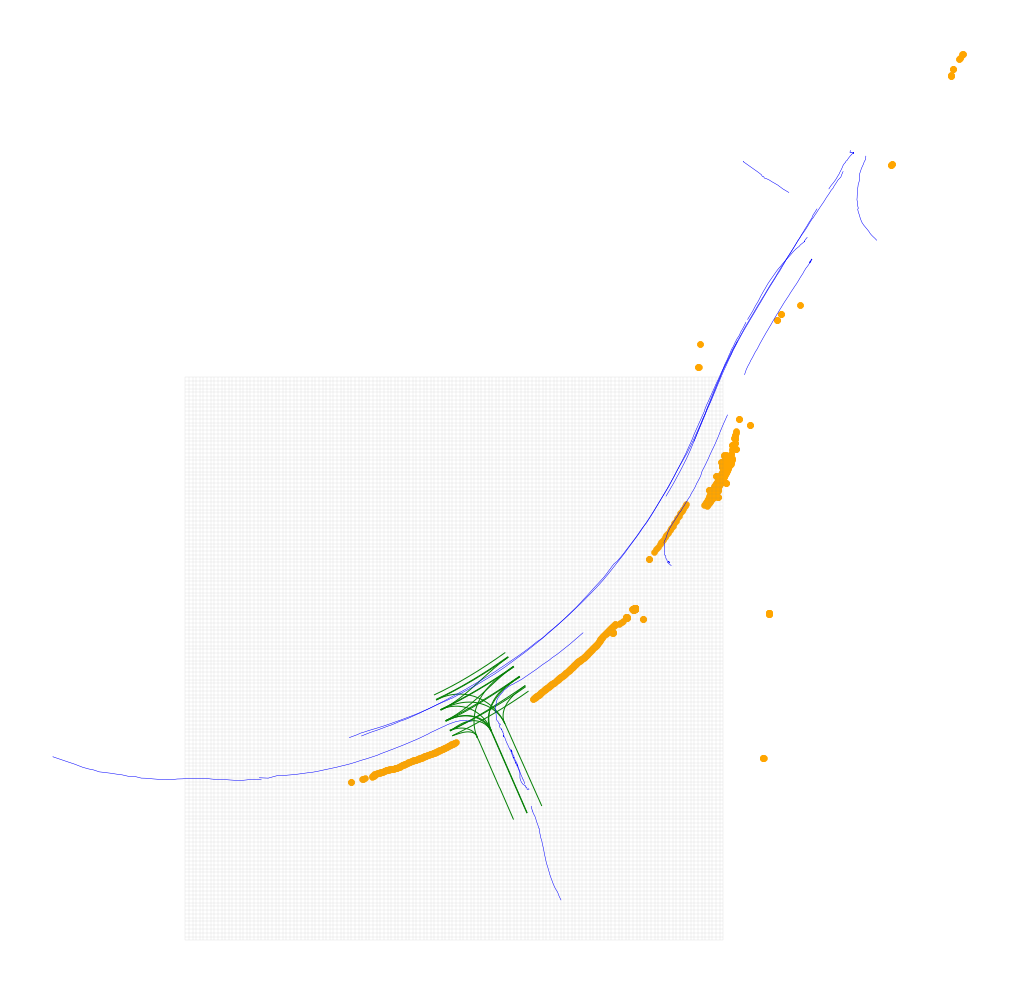

In [10]:
plot_scene_on_grid('8KfB', lane_list=lane_list, \
                           grid_boundary=grid_boundary, veh=veh_traj, ped=ped_traj, cyc=cyc_traj)

In [11]:
def get_downsample(scene, Test, zarr_dataset, intersection_id, grid_boundary):
    """
    get downsampled trajectory in a scene
    return: ego, veh, ped, cyc trajectories
    """
    frame_interval = zarr_dataset.scenes[scene]['frame_index_interval']
    length = frame_interval[1] - frame_interval[0]
#     print(length)
    
    if length<245:
        return None
    


    AV_data = zarr_dataset.frames[frame_interval[0]:frame_interval[1]]
    # store the AV state 
    ego = AV_data['ego_translation'][:,:2]

    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])

    # filter the agents
    car_id_list = []
    for car_id in Test.agent_list[0]:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==car_id)[0]]
        if agent_loc.shape[0] > 30 and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
            car_id_list.append(car_id)
#     print("caridlist",car_id_list)
    
    pedestrian_id_list = []
    for pedestrian_id in Test.agent_list[-1]:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==pedestrian_id)[0]]
        if agent_loc.shape[0] > 10:  # more than 1 sec
            pedestrian_id_list.append(pedestrian_id)
#     print("pedidlist",pedestrian_id_list)
    cyc_id_list = []
    clist=[]
    for c in Test.agent_list[-3]:
        clist.append(c)
    for c in Test.agent_list[-5]:
        clist.append(c)
    for cyc_id in clist:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==cyc_id)[0]]
        if agent_loc.shape[0] > 10:  # more than 1 sec
            cyc_id_list.append(cyc_id)
#     print("cycidlist",cyc_id_list)


#     for car_idx, car_id in enumerate(car_id_list):
#         for frame_idx, frame in enumerate(range(frame_interval[0],frame_interval[1])):
#             agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
#             if car_id in agents_info['track_id']:
#                 scene_state[1+car_idx, frame_idx,0:2] = agents_info[np.where(agents_info['track_id']==car_id)[0]]['centroid'][0]
#                 scene_state[1+car_idx, frame_idx,2] = 2
#                 scene_state[1+car_idx, frame_idx,-1] = car_id
                
                
    # each frame is a 3D tensor: [3,40,150, 150]
    tensor= np.zeros(shape=(3,40,150,150))
    carid_to_fillvalue={}
    fill_value=1
    sampling_id=range(0, 200,5)
    for car_idx, car_id in enumerate(car_id_list):
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if car_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==car_id)[0]]['centroid'][0]
#                 print("extract",car_id, frame,loc)
                x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
                fill_coor = locate_in_mesh(x_mesh[0], y_mesh[:,1], loc)
    #                 print(fill_coor)
                if fill_coor is not None:
                    if car_id in carid_to_fillvalue:
                        fill_value=carid_to_fillvalue[car_id]
                    else:
#                         fill_value+=1
                        carid_to_fillvalue[car_id]=fill_value
    #                     print(carid_to_fillvalue)
                    fill_x, fill_y =fill_coor[0],fill_coor[1]
                    tensor[0][enum_idx][fill_x][fill_y]=fill_value

    pedid_to_fillvalue={}
    ped_fill_value=1
    for ped_idx, ped_id in enumerate(pedestrian_id_list):
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if ped_id in agents_info['track_id']:
                
                loc = agents_info[np.where(agents_info['track_id']==ped_id)[0]]['centroid'][0]
#                 print("extract",car_id, frame,loc)
                x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
                fill_coor = locate_in_mesh(x_mesh[0], y_mesh[:,1], loc)
                
                if fill_coor is not None:
                    if ped_id in pedid_to_fillvalue:
                        ped_fill_value=pedid_to_fillvalue[ped_id]
                    else:
#                         ped_fill_value+=1
                        pedid_to_fillvalue[ped_id]=ped_fill_value
                    
                    fill_x, fill_y =fill_coor[0],fill_coor[1]
                    tensor[1][enum_idx][fill_x][fill_y]=ped_fill_value
#                     print("fillat",1,ped_id, enum_idx, fill_x, fill_y, ped_fill_value)
                    
    cycid_to_fillvalue={}
    cyc_fill_value=1
    for cyc_idx, cyc_id in enumerate(cyc_id_list):
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if cyc_id in agents_info['track_id']:
                
                loc = agents_info[np.where(agents_info['track_id']==cyc_id)[0]]['centroid'][0]
#                 print("extract",car_id, frame,loc)
                x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
                fill_coor = locate_in_mesh(x_mesh[0], y_mesh[:,1], loc)
                
                if fill_coor is not None:
                    if cyc_id in cycid_to_fillvalue:
                        cyc_fill_value=cycid_to_fillvalue[cyc_id]
                    else:
#                         cyc_fill_value+=1
                        cycid_to_fillvalue[cyc_id]=cyc_fill_value
                    
                    fill_x, fill_y =fill_coor[0],fill_coor[1]
                    tensor[2][enum_idx][fill_x][fill_y]=cyc_fill_value
#                     print("fillat",1,cyc_id, enum_idx, fill_x, fill_y, cyc_fill_value)
        
#     # return the state array with 0.5 second per time step
#     return scene_state[:,::5,:]
    return tensor
    



In [12]:
down_sample = get_downsample(3609, Test, zarr_dataset, '8KfB', grid_boundary=grid_boundary) # 2148, 5532

In [13]:
print(down_sample.shape)

(3, 40, 150, 150)


In [14]:
# replot from representation
from collections import defaultdict
def find_traj_samevalue(tensor):
#     print(tensor.shape)
    result_traj=[] #{traj}, traj is 2D, get the occupied points
    for snapshot in tensor:
        max_v = int(np.max(snapshot))
        if max_v==0:
            continue
        loc = np.where(snapshot==1)
        if loc[0].size==0:
            continue
        for i in range(len(loc[0])):
            result_traj.append([loc[0][i]+450, loc[1][i]-2450])
    return result_traj
            
    
def replot_from_representation(scene_tensor, lane_list, intersection_id, grid_boundary):

    veh, ped, cyc = scene_tensor[0], scene_tensor[1], scene_tensor[2]
    veh_traj = find_traj_samevalue(veh)
    ped_traj = find_traj_samevalue(ped)
    cyc_traj = find_traj_samevalue(cyc)
    
    plt.figure(figsize=(18,18))
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)
    

    veh_traj = np.array(veh_traj)
    if len(veh_traj)>0:
        plt.scatter(veh_traj[:,0],veh_traj[:,1], c='b',s=1)
   
    ped_traj = np.array(ped_traj)
    if len(ped_traj)>0:
        plt.scatter(ped_traj[:,0],ped_traj[:,1], c='orange',s=1)
   
    cyc_traj = np.array(cyc_traj)
    if len(cyc_traj)>0:
        plt.scatter(cyc_traj[:,0],cyc_traj[:,1], c='cyan',s=1)
#     if veh is not None:
#         for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
#     if ped is not None:
#         for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
#     if cyc is not None:
#         for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    plt.axis('off')
    plt.show()
    
    

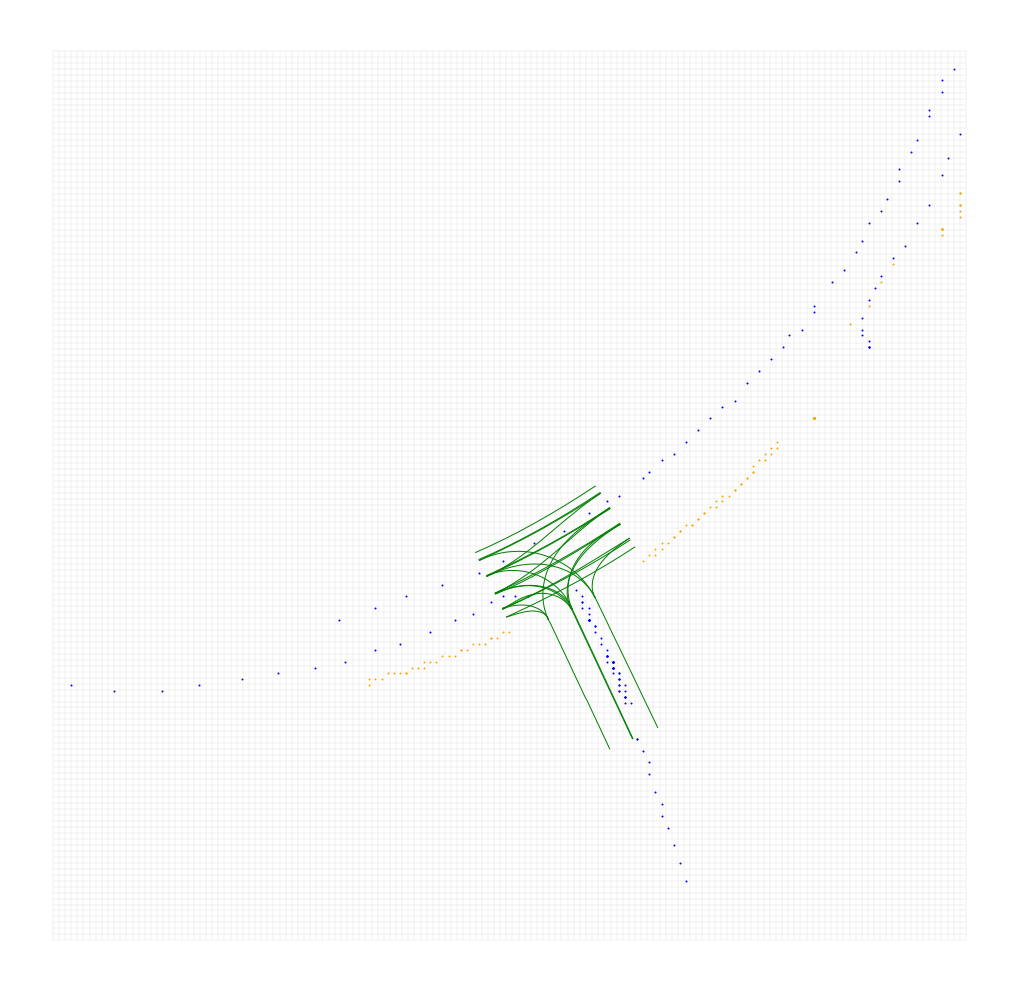

In [15]:
replot_from_representation(down_sample, lane_list=lane_list, intersection_id='8KfB',  \
                           grid_boundary=grid_boundary)

In [16]:
final_tensor=[]
for _, scene in enumerate(junction_8KfB):
    print("i-th, scene", _, scene)
    scene_tensor = get_downsample(scene, Test, zarr_dataset, '8KfB', grid_boundary=grid_boundary) # 3134
    
    if scene_tensor is None:
        continue
    final_tensor.append(scene_tensor)
final_tensor=np.array(final_tensor)  
print("Done", final_tensor.shape)
np.save("8kfb_representation_samevalue", final_tensor)
print('saved')

i-th, scene 0 82
i-th, scene 1 347
i-th, scene 2 380
i-th, scene 3 924
i-th, scene 4 978
i-th, scene 5 1041
i-th, scene 6 1274
i-th, scene 7 1571
i-th, scene 8 1656
i-th, scene 9 1861
i-th, scene 10 2024
i-th, scene 11 2046
i-th, scene 12 2097
i-th, scene 13 2148
i-th, scene 14 2208
i-th, scene 15 2209
i-th, scene 16 2387
i-th, scene 17 2582
i-th, scene 18 2725
i-th, scene 19 2838
i-th, scene 20 3080
i-th, scene 21 3134
i-th, scene 22 3193
i-th, scene 23 3435
i-th, scene 24 3470
i-th, scene 25 3518
i-th, scene 26 3608
i-th, scene 27 3609
i-th, scene 28 3657
i-th, scene 29 3658
i-th, scene 30 3716
i-th, scene 31 3774
i-th, scene 32 3775
i-th, scene 33 3873
i-th, scene 34 4990
i-th, scene 35 5021
i-th, scene 36 5022
i-th, scene 37 5081
i-th, scene 38 5082
i-th, scene 39 5366
i-th, scene 40 5367
i-th, scene 41 5423
i-th, scene 42 5532
i-th, scene 43 5582
i-th, scene 44 5781
i-th, scene 45 5844
i-th, scene 46 5900
i-th, scene 47 5958
i-th, scene 48 6014
i-th, scene 49 6095
i-th, scene 50 6